## Packages

In [1]:
using HalfIntegers
using LinearAlgebra
using ElasticArrays
using JLD2
using Distributed
using DelimitedFiles
using Random
using CSV
using DataFrames
using LsqFit

## Plot style

In [2]:
using Plots
using Plots.PlotMeasures
using LaTeXStrings

# set backend and style
pgfplotsx()
theme(:default)
default(markerstrokewidth = 0, 
        markerstrokealpha = 0, 
        linewidth = 2, 
        #grid=:none,   
        gridlinewidth= 0.5,
        markersize = 5,
        markershape = :circle,
        tickfontsize = 18, 
        size = (900, 600), 
        legendfontsize = 18, 
        guidefontsize=20,
        titlefontsize = 20,
        legend=(0.03,0.98), 
        xticks = 0:10, 
        foreground_color_axis = "black",
        foreground_color_border = "black",
        foreground_color_guide = "darkorange",
        foreground_color_text = "black",
        guidefontcolor = "black", 
        plot_titlefontcolor = "black",
        titlefontcolor = "black", 
        shape=[:circle])
     

## Computational times

In [3]:
DATA_FOLDER = "../../data"

"../../data"

In [4]:
workers = 6
threads = 1
immirzi = 1

#comp_times = Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/computational_times/vertex_computations/immirzi_$(immirzi)_workers_$(workers)_threads_$(threads).csv", header=true)))

1

In [52]:
pl1 = plot(0:1:5, 
    [comp_times[:,9], comp_times[:,4], comp_times[:,7], comp_times[:,8], comp_times[:,5]],
    label=[L"j_0=3.5, \, j_{\pm}=1.5" L"j_0 = 4, \, j_{\pm} = 1.5" L"j_0 = 5, \, j_{\pm} = 2" L"j_0 = 5.5, \, j_{\pm} = 2"],
    markershape = :circle,    
    xticks=[0,1,2,3,4,5],
    yaxis=:log,
    legend=(0.10,0.97), 
    legendfontsize = 18)
    xlabel!(L"\Delta l")
    ylabel!(L"\textrm{seconds}")
    title!(L"\textrm{Computation time of EPRL vertices}")
savefig("./plots/laptop_comp_times_workers_$(workers)_threads_$(threads)_immirzi_$(immirzi).pdf")  

"/home/frisus/Scrivania/BlackToWhiteHole/notebooks/julia/plots/laptop_comp_times_workers_6_threads_1_immirzi_1.pdf"

## Amplitude

In [32]:
function AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

    return Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/alpha_$(alpha)/amplitude_abs_sq_T_$(T).csv", header=true)))

end

AmplitudeAbsSquaredLoad (generic function with 1 method)

In [33]:
function LifetimeLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

    return Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/alpha_$(alpha)/lifetime_$(T).csv", header=true)))

end

LifetimeLoad (generic function with 1 method)

In [49]:
j0 = 2.0
jpm = 1.5
K0 = 0.5
Kpm = 0.5
alpha = 3
T = 100

100

In [50]:
ampls = AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

100×2 Matrix{Float64}:
 1.86366e-292  6.89164e-292
 1.93253e-292  7.18768e-292
 2.00116e-292  7.48053e-292
 2.06863e-292  7.76599e-292
 2.13401e-292  8.04006e-292
 2.19647e-292  8.29911e-292
 2.25529e-292  8.5399e-292
 2.30981e-292  8.75971e-292
 2.35952e-292  8.95636e-292
 2.40405e-292  9.12828e-292
 ⋮             
 1.41768e-292  4.90961e-292
 1.45546e-292  5.08527e-292
 1.49976e-292  5.28768e-292
 1.55001e-292  5.51434e-292
 1.60553e-292  5.76221e-292
 1.66555e-292  6.02784e-292
 1.7292e-292   6.30739e-292
 1.79556e-292  6.59675e-292
 1.86366e-292  6.89164e-292

In [66]:
ampls[:] .= ampls[:] .* 10^30

200-element view(::Vector{Float64}, :) with eltype Float64:
 3.630828827156604e7
 3.76498685659841e7
 3.8987104432320714e7
 4.030141254154482e7
 4.157518143842079e7
 4.2792186462934256e7
 4.393796686931454e7
 4.5000154053619616e7
 4.5968741222109824e7
 4.6836286559097186e7
 ⋮
 9.565001566424634e7
 9.907226481648725e7
 1.0301579560632898e8
 1.0743155660434537e8
 1.1226067148782994e8
 1.174356548019224e8
 1.2288189184206536e8
 1.2851934176022725e8
 1.3426441552026266e8

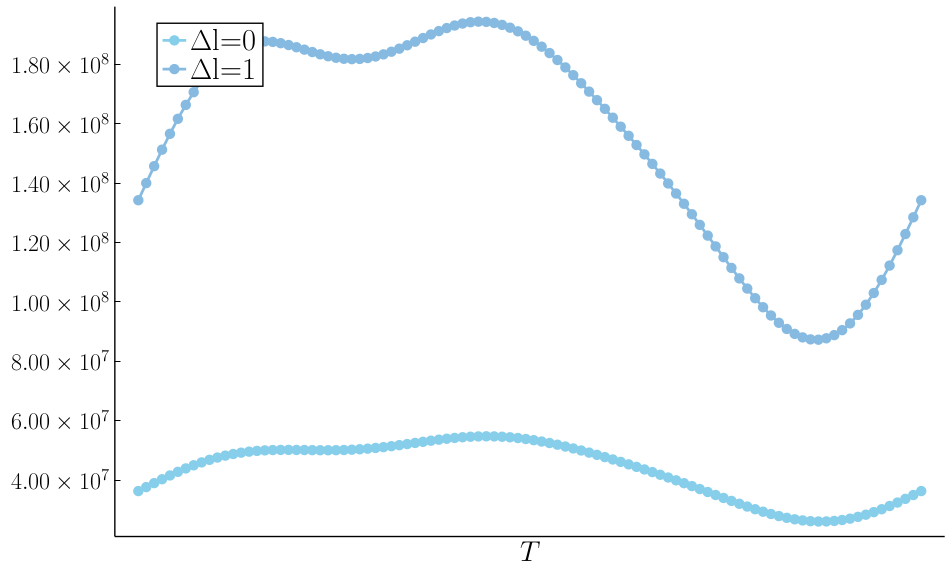

In [67]:
final_x_tick = 100

pl1 = plot(0:99, 
    [ampls[:, 1] ampls[:, 2]],
    label=["Δl=0" "Δl=1"],
    markershape = :circle,    
    grid=:false,
    xticks = (120, round(final_x_tick, digits=3)),
    legend=(0.05,0.97), 
    #palette = palette([:skyblue, :royalblue2, :blue]),
    palette = palette([:skyblue, :purple], 11),
    legendfontsize = 22)
    xlabel!(L"T")
    #title!(L"|W  \, \left(m=1.225, \, \alpha=%immirzi \right) |")
#savefig("(store_folder)/W_alpha_(alpha)_Immirzi_$(immirzi)_m_first.pdf")

In [28]:
ampls = AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, 0.0, alpha, T)

100×2 Matrix{Float64}:
 1.9967e-41   7.25977e-41
 1.98105e-41  7.19886e-41
 1.93465e-41  7.01836e-41
 1.85919e-41  6.72478e-41
 1.7574e-41   6.32873e-41
 1.63295e-41  5.84452e-41
 1.49033e-41  5.28966e-41
 1.33472e-41  4.68421e-41
 1.17172e-41  4.05003e-41
 1.00723e-41  3.41007e-41
 ⋮            
 1.17172e-41  4.05003e-41
 1.33472e-41  4.68421e-41
 1.49033e-41  5.28966e-41
 1.63295e-41  5.84452e-41
 1.7574e-41   6.32873e-41
 1.85919e-41  6.72478e-41
 1.93465e-41  7.01836e-41
 1.98105e-41  7.19886e-41
 1.9967e-41   7.25977e-41

In [30]:
ampls[:] .= ampls[:] .* 10^20

200-element view(::Vector{Float64}, :) with eltype Float64:
 0.001204311767381451
 0.0011948704345339746
 0.0011668876703598084
 0.0011213748448645883
 0.001059976910144222
 0.0009849129475302605
 0.0008988959642088196
 0.0008050348380722014
 0.0007067219547717615
 0.0006075105980616964
 ⋮
 0.002442782182700372
 0.002825284265136222
 0.003190466070427353
 0.0035251289766586235
 0.0038171773944431476
 0.004056055933037456
 0.004233130899664783
 0.004342002343666899
 0.004378735367395787

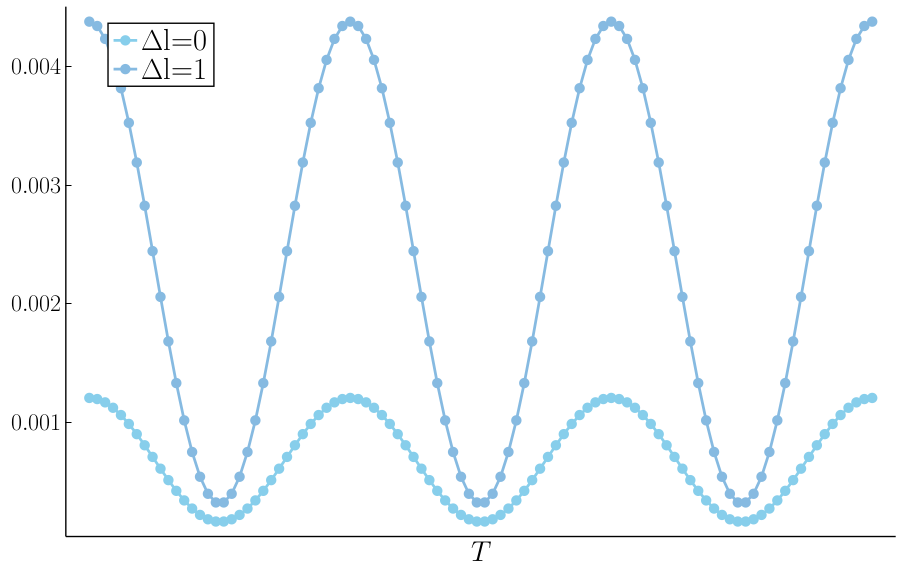

In [31]:
final_x_tick = 100

pl1 = plot(0:99, 
    [ampls[:, 1] ampls[:, 2]],
    label=["Δl=0" "Δl=1"],
    markershape = :circle,    
    grid=:false,
    xticks = (120, round(final_x_tick, digits=3)),
    legend=(0.05,0.97), 
    #palette = palette([:skyblue, :royalblue2, :blue]),
    palette = palette([:skyblue, :purple], 11),
    legendfontsize = 22)
    xlabel!(L"T")
    #title!(L"|W  \, \left(m=1.225, \, \alpha=%immirzi \right) |")
#savefig("(store_folder)/W_alpha_(alpha)_Immirzi_$(immirzi)_m_first.pdf")

In [68]:
using SL2Cfoam

In [69]:
immirzi = 1

conf_sl2cfoam_next = SL2Cfoam.Config(VerbosityOff, HighAccuracy, 100, 0)
SL2Cfoam.cinit("/home/frisus/Scrivania/sl2cfoam-next-dev/data_sl2cfoam", immirzi, conf_sl2cfoam_next)


In [71]:
theta = acos(-sqrt(2 / 3))
phi_1 = 0
phi_2 = 2 * pi / 3
phi_3 = -2 * pi / 3;


In [85]:
c1 = coherentstate_compute([half(2) half(2) half(2) half(2)],
[[phi_1, phi_2, phi_3, 0] [theta, theta, theta, 0]]);

@show c1.a

c1.a = ComplexF64[-0.14583333333333337 - 0.1178511301977578im, -0.12629537138523067 - 0.10206207261596564im, -0.032609324671871935 - 0.026352313834736463im]


3-element Vector{ComplexF64}:
  -0.14583333333333337 - 0.1178511301977578im
  -0.12629537138523067 - 0.10206207261596564im
 -0.032609324671871935 - 0.026352313834736463im

In [86]:
c1 = coherentstate_compute([half(2) half(2) half(2) half(2)],
[[0, phi_1, phi_2, phi_3] [0, theta, theta, theta]]);

@show c1.a

c1.a = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, -0.19565594803123162 - 0.15811388300841878im]


3-element Vector{ComplexF64}:
                  0.0 + 0.0im
                  0.0 + 0.0im
 -0.19565594803123162 - 0.15811388300841878im

In [81]:
[[theta, theta, theta, 0] [phi_1, phi_2, phi_3, 0]]

4×2 Matrix{Float64}:
 2.52611   0.0
 2.52611   2.0944
 2.52611  -2.0944
 0.0       0.0